![alt text](https://www.zupimages.net/up/19/48/7ncl.png)

# Test technique - Session 11/2019
---

Il est très important pour un site de e-commerce de maximiser son taux de conversion afin d'optimiser son budget référencement et publicité. <br/>
La société DOTAKI propose de déterminer le profil de chaque nouvel utilisateur en fonction de son comportement sur le site pendant une courte durée de temps et de lui attribuer un profil type. <br/>
Durant ce test nous allons analyser les données récupées lors d'un A/B test et essayer de déterminer quelle page doit être affichée en fonction du profil de l'utilisatuer

# Sommaire
1. [Partie 0: Exploration du dataset](#Part0)
    1. [Visualisation des données](#1A)
    2. [Formatage des données](#1B)
    3. [Calcul des taux de conversion](#1C)
    4. [Significativité](#1D)


2. [Partie 1: Généralisation grâce à une fonction](#Part1) <br/>

    1. [Création de la fonction](#2A)
    2. [Comment adapter ce programme pour un nombre de variantes N (supérieur à 2) ?](#2B)
    3. [Quelle variante retenir dans le cas où la variante B présente un taux de conversion supérieure mais un panier moyen inférieur à la variante A ?](#2C)


3. [Partie 2 – Machine learning](#Part2)
    1. [Détèrmination des segments les plus convertis](#3A)
    2. [Détèrmination des segment les plus convertis en fonction de la variante affichée](#3B)
    3. [Limitations](#3C)

# Partie 0: Exploration du dataset<a name="Part0"></a>

## A. Visualisation des données<a name="1A"></a>

Pour commencer nous allons importer les librairies nécessaires et regarder ce que contient ce datage avec la fonction `head`

In [2]:
import pandas as pd

In [3]:
import pandas as pd
ab_test = pd.read_csv('ab_test_sample.csv', sep=';')
ab_test.head(3)

,user_id_zws,variationname,converted,A,O,N,E,C,segment
0,oMRkZI1J,Variation 2,0.0,2.592746,2.472192,2.362454,2.504104,2.423836,Audacious
1,lmTUiwSi,Variation 2,0.0,2.345392,2.276925,1.782853,2.302870,2.490744,Audacious
2,9sfYSKLB,Original,0.0,2.403846,2.602851,2.114951,2.212326,2.251903,Straightforwards


## B. Formatage des données<a name="1B"></a>

Nous pouvons simplement trouver le nombre de visiteurs et de convertis pour les deux variations.
* Nous commençons par filtrer le dataset 
* On utilise ensuite la fonction `nunique` qui nous donne le nombre d'éléments uniques dans une série

In [4]:
visitor_B = ab_test[ab_test['variationname'] == "Variation 1"]['user_id_zws'].nunique()
converted_B = ab_test[(ab_test['variationname'] == "Variation 1") & (ab_test['converted'] == 1.0)]['user_id_zws'].nunique()

visitor_A = ab_test[ab_test['variationname'] == "Variation 2"]['user_id_zws'].nunique()
converted_A = ab_test[(ab_test['variationname'] == "Variation 2") & (ab_test['converted'] == 1.0)]['user_id_zws'].nunique()

On peut ensuite créer un DataFrame contenant les variables que nous venons de créer

In [5]:
data = pd.DataFrame({
    "Converted": [converted_A, converted_B],
    "Total": [visitor_A, visitor_B]
    }, index=['Variation A', 'Variation B'])

data.head()

,Converted,Total
Variation A,251,2116
Variation B,236,2101


## C. Calcul des taux de conversion<a name="1C"></a>

Cela nous permet de très simplement faire des opérations sur les colonnes pour obtenir les taux de conversions des deux pages très simplement

In [6]:
data['Conversion_rate'] = data['Converted']/data['Total']*100
data.head()

,Converted,Total,Conversion_rate
Variation A,251,2116,11.862004
Variation B,236,2101,11.232746


In [7]:
# conversionRate_gain = (conversionRate_B-conversionRate_A) / conversionRate_A * 100
# conversionRate_gain

## D. Significativité<a name="1D"></a>

On obtient la **p-valeur** grâce à la fonction `proportions_ztest` qui nous donne un indice sur la significativité du taux de conversion

In [8]:
from statsmodels.stats.proportion import proportions_ztest

proportions_ztest(count=data.Converted, nobs=data.Total, alternative='smaller')

(0.6392667869844965, 0.7386753045156282)

Ici la **p-valeur** vaut 0,74 le taux te conversion n'est donc pas significatif

# Partie 1: Généralisation grâce à une fonction<a name="Part1"></a>

## A. Création de la fonction<a name="2A"></a>

Après avoir découvert ces valeurs, il semble intéressant de généraliser cette méthode dans une fonction.
Pour faire nos calculs nous avons besoin de plusieurs formules<br/>
* $Taux\, de\, conversion  = \frac{Nombre\, de\, convertis}{nombre\, de\, visiteurs\,}\times100$
<br/><br/>
* $Gain\, de\, taux\, de\, conversion = \frac{Taux\, de\, conversion\, B\, - Taux\, de\, conversion\, A}{Taux\, de\, conversion\, A}\times100$

In [5]:
def toDo(nbVisiteurs_A, nbConvertis_A, panierMoyen_A, nbVisiteurs_B, nbConvertis_B, panierMoyen_B ):
    
    conversionRate_A = nbConvertis_A/nbVisiteurs_A*100
    conversionRate_B = nbConvertis_B/nbVisiteurs_B*100
    
    conversionRate_gain = (conversionRate_B-conversionRate_A) / conversionRate_A * 100
    
    panierGain = (panierMoyen_B-panierMoyen_A) / panierMoyen_A * 100
    
    v, p_conversion = proportions_ztest(count=pd.Series([nbConvertis_A, nbConvertis_B]), nobs=pd.Series([nbVisiteurs_A,nbVisiteurs_B]), alternative='smaller')
    significativite = 100.0- p_conversion * 100
    
    d = dict()
    d['conversionRate_gain'] = str(conversionRate_gain) + " %"
    d['significativite'] = str(significativite) + " %"
    d['panierGain'] = str(panierGain) + " %"
    
    return d

On teste notre fonction avec les valeurs du dataset

In [10]:
toDo(2116, 251, 10, 2101, 236, 15)

{'conversionRate_gain': '-5.304815957493203 %',
 'significativite': '26.13246954843717 %',
 'panierGain': '50.0 %'}

## B. Comment adapter ce programme pour un nombre de variantes N (supérieur à 2) ? <a name="2B"></a>

Pour plus de **variante** que 2, il va falloir comparer les taux de conversion de chaque variante à la page originale. <br/>
On choisira la variante qui a le **gain relatif** le plus grand. 

## C. Quelle variante retenir dans le cas où la variante B présente un taux de conversion supérieure mais un panier moyen inférieur à la variante A ?<a name="2C"></a>

Dans ce cas là on multipliera le taux de conversion par le panier moyen de chaque variante. <br/>
On choisira  la variante qui a le produit le plus haut

# Partie 2: Machine learning<a name="Part2"></a>

## A. Détèrmination des segments les plus convertis<a name="3A"></a>

On nous demande d'évaluer quelle variation de la page doit être affichée pour chaque `segment`. <br/>

On peut commencer par analyser les segments ayant le meilleur taux de conversion
* on commence par grouper par segment
* la fonction `count` nous donne le nombre total de colonne de chaque segment.
* la fonction `sum` appliqué à la colonne `converted` nous donne le nombre de convertis. par segment

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

type(ab_test.groupby('segment')['converted'].sum())
convertedPerSegment = pd.DataFrame({
    "Segment": [x for x in ab_test['segment'].unique()],
    "Total": [x for x in ab_test.groupby('segment')['converted'].count()],
    "Converted": [x for x in ab_test.groupby('segment')['converted'].sum()]
    })

convertedPerSegment

,Segment,Total,Converted
0,Audacious,658,89.0
1,Straightforwards,1195,104.0
2,Homebodies,611,52.0
3,Emotives,645,72.0
4,Altruists,624,61.0
5,Hedonists,2157,284.0
6,Conventionals,447,40.0
7,Analyticals,1093,113.0
8,Trend Setters,653,66.0
9,Attentives,455,63.0


On peut maintenant recalculer le taux de conversion par segment avec la même formule que précédemment.<br/>
$Taux\, de\, conversion  = \frac{Nombre\, de\, convertis}{nombre\, de\, visiteurs\,}\times100$

<BarContainer object of 10 artists>

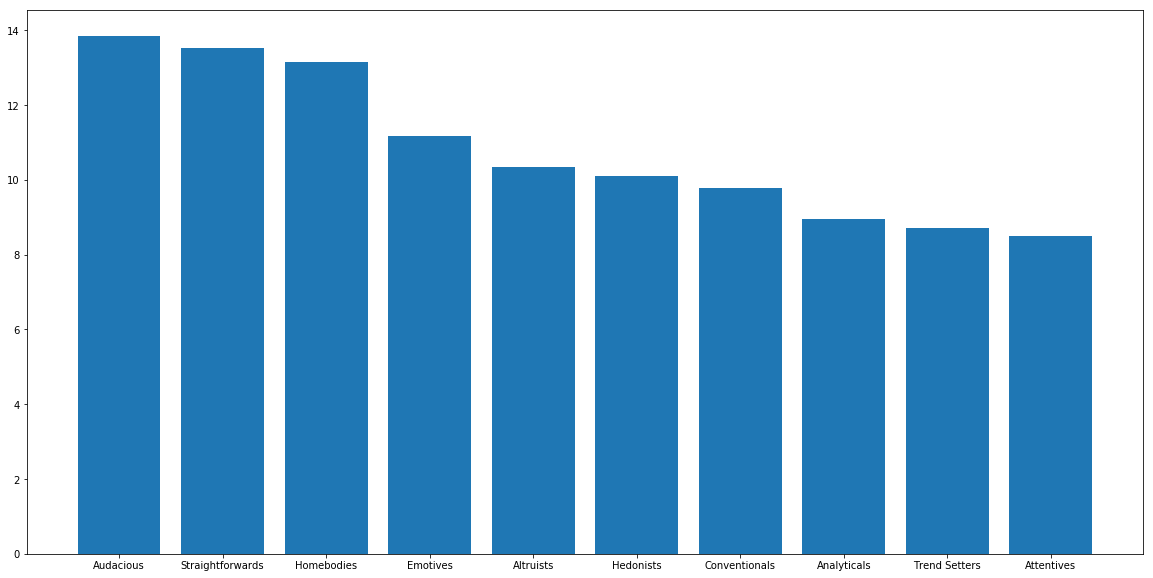

In [16]:
convertedPerSegment['Conversion_rate'] = convertedPerSegment['Converted']/convertedPerSegment['Total'] * 100

figure(figsize=(20, 10))
plt.bar(convertedPerSegment['Segment'], convertedPerSegment['Conversion_rate'].sort_values(ascending = False) )

Ce graphe nous donne plusieurs informations :
* On remarque que le segment **Audacious** est celui qui à le taux de conversion le plus important, il peut donc être intéressant de le cibler en priorité. <br/>
* En revanche le segment **Attentives** est celui qui à le taux de conversion le plus bas, il sera important de prendre cette donnée en compte lorsque l'on fera des publicités ciblées par exemple.

## B. Détèrmination des segment les plus convertis en fonction de la variante affichée. <a name="3B"></a>

Il est intéressant de construire un tavbleau ayant plusieurs index.
* Nous prendrons en premier index: **le segment**
* et en deuxième index: **la variation utilisée**

Pour faire cela on passera un **tableau** en argument de la fonction `groupby`

In [21]:
ab_test = ab_test[ab_test['variationname'] != 'Original bis']
converted = ab_test.groupby(['segment', 'variationname'])['converted'].sum()
total = ab_test.groupby(['segment', 'variationname'])['converted'].count()

On passe ensuite la série multi indexé en paramètre de la fonction pandas `DataFrame`

In [22]:
data = pd.DataFrame(converted)
data['total'] = total

On peut donc très facilement calculer le taux de conversion de chaque segment sur chaque variation grâce à un calcul de colonne simple

In [23]:
data['convrsion_rate'] = data['converted']/data['total'] * 100

On récupère dans un tableau toutes les valeurs prises par `segment`

In [25]:
segments = data.index.get_level_values(0).unique()

Pour déterminer le varation à utiliser on récupère la valeur en index du plus haut taux de conversion par `segment`

In [24]:
for x in segments:
    data.loc[x, 'best_variation'] = data.loc[x][data.loc[x]['convrsion_rate'] == data.loc[x]['convrsion_rate'].max()].index[0]

converted  total  convrsion_rate  \
segment          variationname                                     
Altruists        Original            17.0    172        9.883721   
                 Variation 1         22.0    166       13.253012   
                 Variation 2         19.0    145       13.103448   
Analyticals      Original            21.0    298        7.046980   
                 Variation 1         24.0    299        8.026756   
                 Variation 2         30.0    292       10.273973   
Attentives       Original             8.0    150        5.333333   
                 Variation 1         19.0    164       11.585366   
                 Variation 2         15.0    148       10.135135   
Audacious        Original            10.0    166        6.024096   
                 Variation 1         21.0    154       13.636364   
                 Variation 2         23.0    167       13.772455   
Conventionals    Original            21.0    159       13.207547   
                 Variation 1         13.0    154        8.441558   
                 Variation 2         13.0    165        7.878788   
Emotives         Original            72.0    572       12.587413   
                 Variation 1         64.0    506       12.648221   
                 Variation 2         74.0    535       13.831776   
Hedonists        Original            13.0    134        9.701493   
                 Variation 1          7.0    107        6.542056   
                 Variation 2         12.0    103       11.650485   
Homebodies       Original            23.0    249        9.236948   
                 Variation 1         33.0    281       11.743772   
                 Variation 2         30.0    285       10.526316   
Straightforwards Original            16.0    172        9.302326   
                 Variation 1         17.0    157       10.828025   
                 Variation 2         17.0    159       10.691824   
Trend Setters    Original            18.0    117       15.384615   
                 Variation 1         16.0    113       14.159292   
                 Variation 2         18.0    117       15.384615   

                               best_variation  
segment          variationname                 
Altruists        Original         Variation 1  
                 Variation 1      Variation 1  
                 Variation 2      Variation 1  
Analyticals      Original         Variation 2  
                 Variation 1      Variation 2  
                 Variation 2      Variation 2  
Attentives       Original         Variation 1  
                 Variation 1      Variation 1  
                 Variation 2      Variation 1  
Audacious        Original         Variation 2  
                 Variation 1      Variation 2  
                 Variation 2      Variation 2  
Conventionals    Original            Original  
                 Variation 1         Original  
                 Variation 2         Original  
Emotives         Original         Variation 2  
                 Variation 1      Variation 2  
                 Variation 2      Variation 2  
Hedonists        Original         Variation 2  
                 Variation 1      Variation 2  
                 Variation 2      Variation 2  
Homebodies       Original         Variation 1  
                 Variation 1      Variation 1  
                 Variation 2      Variation 1  
Straightforwards Original         Variation 1  
                 Variation 1      Variation 1  
                 Variation 2      Variation 1  
Trend Setters    Original            Original  
                 Variation 1         Original  
                 Variation 2         Original

On a donc dans la colonne best_variation la variation à afficher en fonction du segment de l'utilisateur

## C. Limitations<a name="3C"></a>

On voit que pour chaque segment nous avons qu'un très petit échantillon. <br/>
Il serait donc intéressant d'enregistrer pendant plus longtemps les données afin d'avoir des résultats significatifs.